# Layered Network

##### Imports

In [34]:
# Custom Modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'modules')))
from hh_model import HodgkinHuxleyNeuron

# Standard Modules
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection, Poly3DCollection

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

### Single Network

##### Directed Erdos-Renyi Graph

In [35]:
def generate_erdos_renyi_digraph(n, p, s=''):
    # Create an empty directed graph
    G = nx.DiGraph()
    
    # Add nodes with custom names
    names = [s + str(i) for i in range(n)]
    for name in names:
        G.add_node(name)  # Assuming HodgkinHuxleyNeuron() is defined elsewhere
    
    # Add edges based on Erdos-Renyi probability
    for i, u in enumerate(names):
        for j, v in enumerate(names):
            if i != j and random.random() < p:
                G.add_edge(u, v)
    
    # Remove bidirectional edges
    for u, v in list(G.edges()):
        if G.has_edge(v, u):
            G.remove_edge(v, u)
    
    # Create neuron objects
    for node in G.nodes():
        G.nodes[node]['neuron'] = HodgkinHuxleyNeuron()
    
    return G

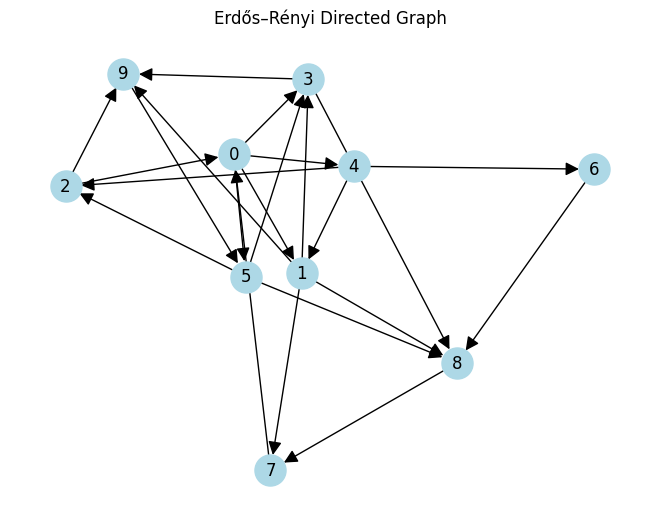

In [36]:
# Parameters
n = 10
p = 0.3

# Generate the graph
digraph = generate_erdos_renyi_digraph(n, p)

# Draw the graph
pos = nx.spring_layout(digraph)
nx.draw(digraph, pos, with_labels=True, node_color='lightblue', node_size=500, arrowsize=20)
plt.title("Erdős–Rényi Directed Graph")
plt.show()

In [37]:
print(digraph.nodes())

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


##### Layered Network

g0 h3
g1 h1
g1 h9
g2 h5
g3 h1


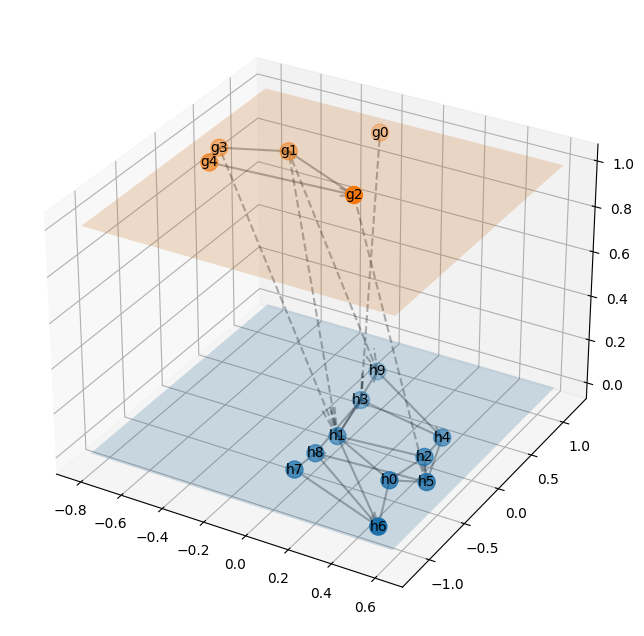

In [38]:
class LayeredNetworkGraph(object):

    def __init__(self, graphs, inter_prob=0.0, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.inter_prob = inter_prob
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])

    def get_edges_between_layers(self):
        """Forms connections between nodes from different layers, thus connecting the layers"""
        self.edges_between_layers = []
        for z1, h in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            g = self.graphs[z2]

            h_nodes = list(h.nodes())

            for node1 in g.nodes():
                for node2 in h_nodes:
                    if random.random() < self.inter_prob:
                        print(node1, node2)
                        h.add_node(node1)
                        h.add_edge(node1, node2)
                        self.edges_between_layers.append(((node1, z2), (node2, z1)))


    def get_node_positions(self, *args, **kwargs):
        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        # Hardcoded arrow size
        arrow_size = 0.1  # Control the size of the arrowhead here
        
        # Extract color from kwargs if it's passed
        color = kwargs.get('color', 'blue')  # Default to 'blue' if not provided
        
        # Remove 'color' from kwargs to avoid conflict
        kwargs = {key: value for key, value in kwargs.items() if key != 'color'}

        for source, target in edges:
            # print((source, target)) 
            start = self.node_positions[source]
            end = self.node_positions[target]

            # Calculate direction vector
            direction = np.array(end) - np.array(start)  
            length = np.linalg.norm(direction)
            direction /= length  # Normalize direction

            # Set up the quiver to draw arrows
            self.ax.quiver(start[0], start[1], start[2], 
                           direction[0], direction[1], direction[2], 
                           length=length, color=color, 
                           arrow_length_ratio=arrow_size, *args, **kwargs)

    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, *args, **kwargs):
        for node, z in self.nodes:
            ax.text(*self.node_positions[(node, z)], node, *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=150, zorder=3)

        self.draw_node_labels(horizontalalignment='center',
                              verticalalignment='center',
                              zorder=100)


if __name__ == '__main__':
    n = 10
    g = generate_erdos_renyi_digraph(int(n/2), p=0.3, s='g')
    h = generate_erdos_renyi_digraph(n, p=0.3, s='h')
    prob_inter = 0.1

    # initialise figure and plot
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    LayeredNetworkGraph([g, h][::-1], prob_inter, ax=ax, layout=nx.spring_layout)
    # ax.set_axis_off()
    plt.show()

In [40]:
for pred in h.predecessors('h1'):
    print(pred)

h0
h2
h3
g1
g3
